In [1]:
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt

In [11]:
import scipy

# Problem 1

## (A)

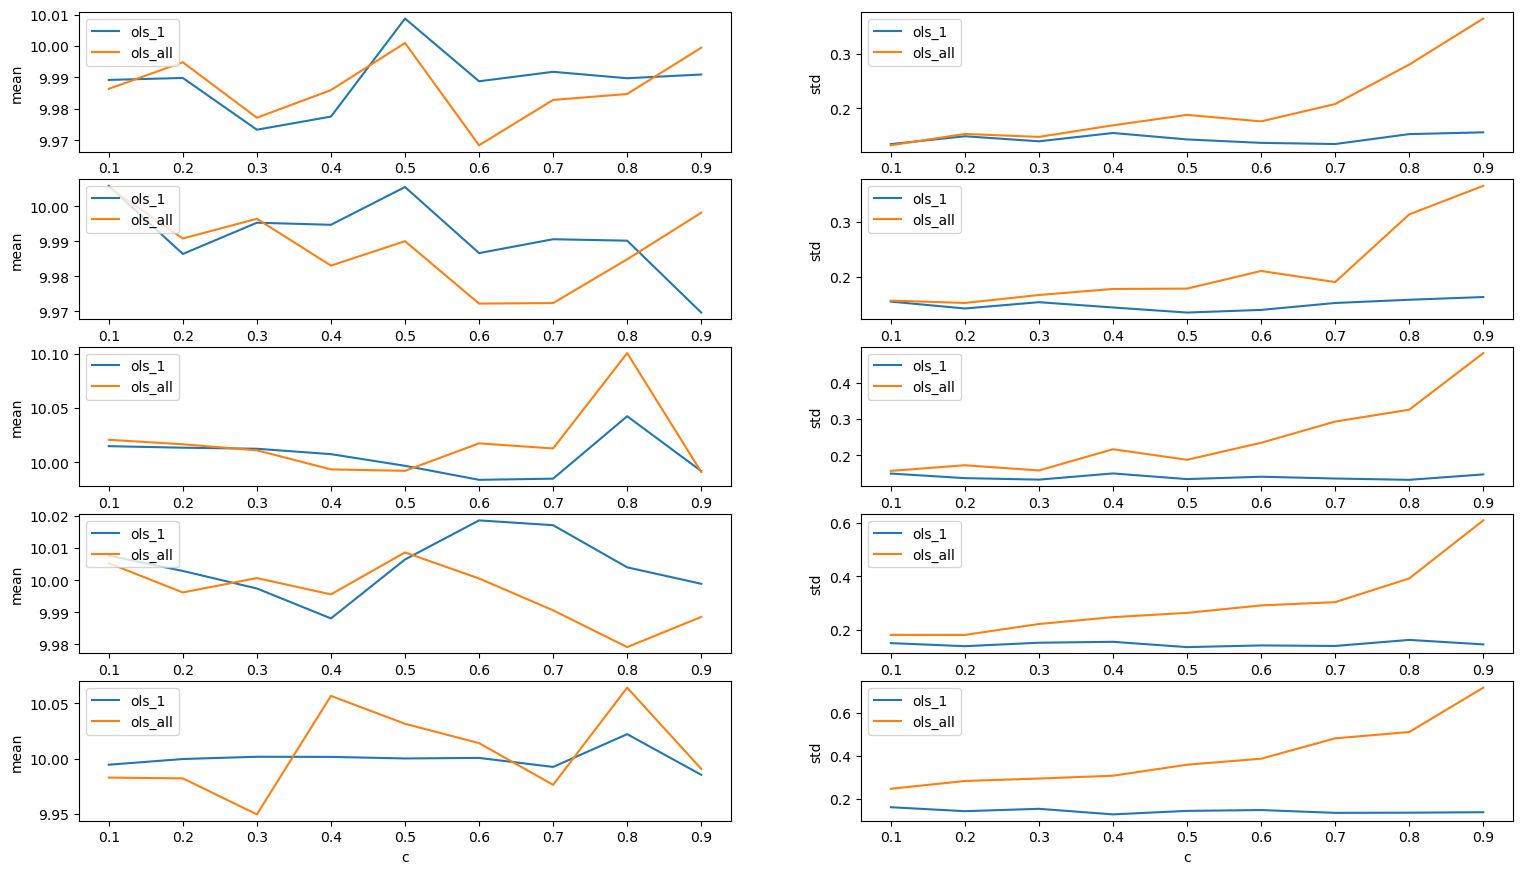

In [94]:
import numpy as np
# Pick w_true
w_true = torch.Tensor([10])

# Parameters
N = 50
T = 100
c_list = np.arange(1,10) * 0.1 # off-diagonal
D_list = [2,4,8,16,32]

# Step 2
def compute_mean_std_iter(D, c):

    mean = [0]*D
    cov = c * np.ones((D, D)) - np.diag([c-1] * D)
    
    # Generating dataset
    x = torch.Tensor(np.random.multivariate_normal(mean, cov, size = N))
    epsilon = torch.randn(size = (N,))
    y = torch.Tensor(np.diag([w_true.item()] * N)).matmul(x[:,0]) + epsilon


    # Compute OLS
    # OLS_1
    x_1 = x[:,0]
    w_OLS_1 = (x_1.dot(y) / x_1.dot(x_1))

    # OLS_all
    w_OLS_all_1 = (torch.inverse(x.t().matmul(x)) @ (x.t().matmul(y)))[0]

    return w_OLS_1, w_OLS_all_1


# Step 3
def run_T_iters(D, c, T = 100):
    w_OLS_1_list = []
    w_OLS_all_1_list = []
    for i in range(T):
        w_OLS_1,w_OLS_all = compute_mean_std_iter(D, c)
        w_OLS_1_list.append(w_OLS_1)
        w_OLS_all_1_list.append(w_OLS_all)

    w_OLS_1_mean = torch.stack(w_OLS_1_list, dim = 0).mean(dim = 0)
    w_OLS_1_std = torch.stack(w_OLS_1_list, dim = 0).std(dim = 0)

    w_OLS_all_1_mean = torch.stack(w_OLS_all_1_list, dim = 0).mean(dim = 0)
    w_OLS_all_1_std = torch.stack(w_OLS_all_1_list, dim = 0).std(dim = 0)

    return (w_OLS_1_mean, w_OLS_1_std, w_OLS_all_1_mean, w_OLS_all_1_std)


# Step 4
def run_D_c(c_list, D_list):



    fig, axs = plt.subplots(5, 2)
    fig.set_size_inches(18.5, 10.5)

    for i, D in enumerate(D_list):

        res_list = [run_T_iters(D, c) for c in c_list]

        w_OLS_1_mean = list(map(lambda group: group[0], res_list))
        w_OLS_1_std = list(map(lambda group: group[1], res_list))
        w_OLS_all_1_mean = list(map(lambda group: group[2], res_list))
        w_OLS_all_1_std = list(map(lambda group: group[3], res_list))

        axs[i, 0].plot(c_list, w_OLS_1_mean, label="ols_1")
        axs[i, 0].plot(c_list, w_OLS_all_1_mean, label = 'ols_all')
        axs[i, 0].set_xlabel("c")
        axs[i, 0].set_ylabel("mean")

        axs[i, 1].plot(c_list, w_OLS_1_std, label="ols_1")   
        axs[i, 1].plot(c_list, w_OLS_all_1_std, label = 'ols_all')
        axs[i, 1].set_xlabel("c")
        axs[i, 1].set_ylabel("std")

        axs[i, 0].legend(loc='upper left')
        axs[i, 1].legend(loc='upper left')

    plt.show()

run_D_c(c_list, D_list)

# Problem 2

## (A)

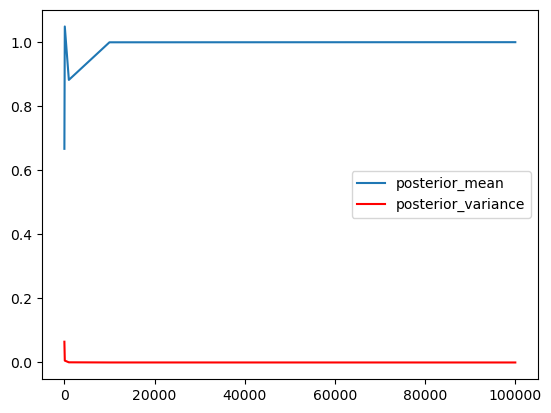

In [89]:
class BLRM_A(Dataset):
    def __init__(self, size = 100, data = None, labels = None):

        self.data = self.generate_data(size)[0] if data is None else data
        self.labels = self.generate_data(size)[1] if labels is None else labels
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Retrieve the sample and label at the specified index
        
        sample = self.data[index]
        label = self.labels[index]

        return sample, label
    
    def compute_X_mean(self):
        return self.data

    def generate_data(self, size, w_true = 1):
        # Parameters for data generation
        sigma_epsilon = 1

        # Generate random inputs x ~ N(0, 1)
        x = torch.randn(size) 

        # Generate outputs 
        epsilon = sigma_epsilon * torch.randn(size)
        y = w_true * x.pow(2) + epsilon

        return (x,y)


def compute_posterior_A(x, y, prior_mean, prior_variance, likeli_variance):
    N = list(x.size())[0]

    posterior_mean = (x.dot(y) * prior_variance + prior_mean * likeli_variance) / (prior_variance * (x.dot(x)) + likeli_variance)
    posterior_variance =  (likeli_variance * prior_variance) / (prior_variance * x.dot(x) + likeli_variance)
    return posterior_mean, posterior_variance


N_list = [10, 100, 1000, 10000, 100000]

posterior_mean_list = []
posterior_variance_list = []
for N in N_list:
    dataset_N = BLRM_A(N)

    likeli_variance = 1
    prior_mean = 0
    prior_variance = 1
    posterior_mean, posterior_variance = compute_posterior_A(dataset_N.data, dataset_N.labels, prior_mean, prior_variance, likeli_variance)
    posterior_mean_list.append(posterior_mean)
    posterior_variance_list.append(posterior_variance)

plt.plot(N_list, posterior_mean_list, label="posterior_mean")
plt.plot(N_list, posterior_variance_list, c="red", label="posterior_variance")
plt.legend()


# (C)

In [98]:
class BLRM_C(Dataset):
    def __init__(self, size = 100, data = None, labels = None):

        self.data = self.generate_data(size)[0] if data is None else data
        self.labels = self.generate_data(size)[1] if labels is None else labels
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Retrieve the sample and label at the specified index
        
        sample = self.data[index]
        label = self.labels[index]

        return sample, label
    
    def compute_X_mean(self):
        return self.data

    def generate_data(self, size, w_true = 1):
        # Parameters for data generation
        sigma_epsilon = 1

        # Generate random inputs x ~ N(0, 1)
        x = torch.randn(size)

        # Generate outputs 
        epsilon = sigma_epsilon * torch.randn(size)
        y = w_true * x.pow(2) + epsilon

        return (x,y)

def compute_posterior_C(x, y, prior_mean, prior_variance, likeli_variance):
    # Construct data matrix
    x = x.reshape(-1,1)
    X = torch.cat([x, x.pow(2)],dim = 1)

    posterior_variance = torch.inverse(torch.inverse(prior_variance) + (1 / likeli_variance) * X.t().matmul(X))
    posterior_mean = posterior_variance.matmul(torch.inverse(prior_variance).matmul(prior_mean) + (1 / likeli_variance) * X.t().matmul(y))

    return posterior_mean, posterior_variance


N_list = [10, 100, 1000, 10000]

posterior_mean_list = []
posterior_variance_list = []
for N in N_list:
    dataset_N = BLRM_C(N)

    likeli_variance = 1
    prior_mean = torch.Tensor(np.array([0,0]))
    prior_variance = torch.Tensor(np.array([[1,0],[0,1]]))
    posterior_mean, posterior_variance = compute_posterior_C(dataset_N.data, dataset_N.labels, prior_mean, prior_variance, likeli_variance)
    posterior_mean_list.append(posterior_mean)
    posterior_variance_list.append(posterior_variance)

print(posterior_mean_list)
print(posterior_variance_list)

[tensor([ 0.9784, -0.1960]), tensor([0.0695, 0.3556]), tensor([0.0383, 0.3553]), tensor([0.0100, 0.3335])]
[tensor([[ 0.3384, -0.1367],
        [-0.1367,  0.0751]]), tensor([[0.0101, 0.0022],
        [0.0022, 0.0034]]), tensor([[1.0018e-03, 3.7392e-05],
        [3.7392e-05, 3.6821e-04]]), tensor([[1.0177e-04, 7.9674e-07],
        [7.9674e-07, 3.4257e-05]])]


# Problem 5

## (A)

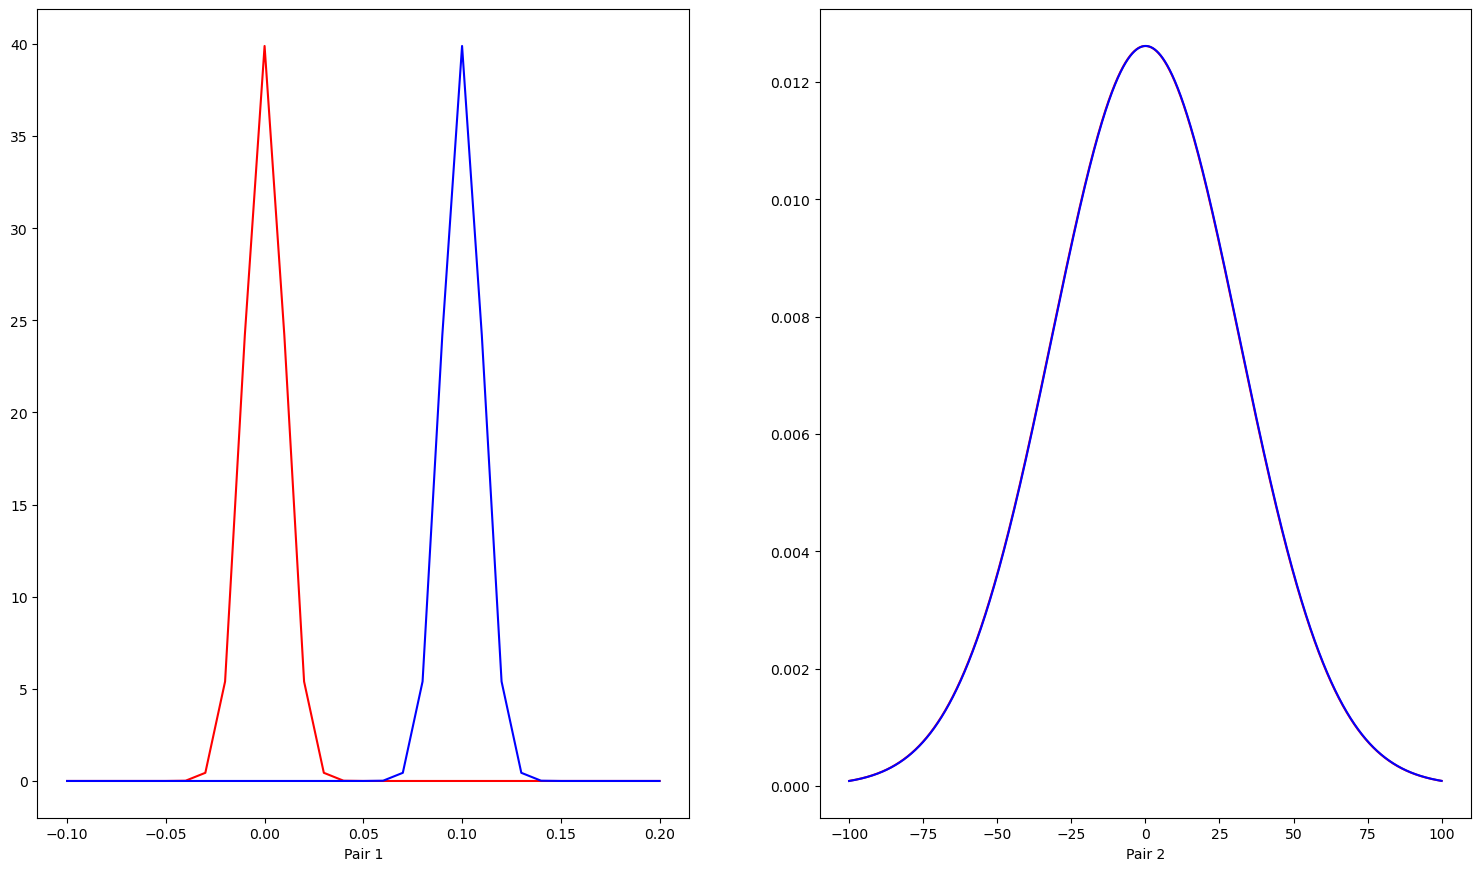

In [120]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm 
import statistics 
  
# Plot between -10 and 10 with .001 steps. 
x_axis_1 = np.arange(-0.1, 0.2, 0.01) 
x_axis_2 = np.arange(-100, 100, 0.01)   

# Plot
fig, axs = plt.subplots(1,2)

fig.set_size_inches(18.5, 10.5)
axs[0].plot(x_axis_1, norm.pdf(x_axis_1, 0, np.sqrt(0.0001)), c="red")
axs[0].plot(x_axis_1, norm.pdf(x_axis_1, 0.1, np.sqrt(0.0001)), c="blue")
axs[0].set_xlabel("Pair 1")

axs[1].plot(x_axis_2, norm.pdf(x_axis_2, 0, np.sqrt(1000)), c="red")
axs[1].plot(x_axis_2, norm.pdf(x_axis_2, 0.1, np.sqrt(1000)), c="blue")
axs[1].set_xlabel("Pair 2")
plt.show() 

## (B)

In [126]:
mu_1_1 = 0
sigma_1_1 = np.sqrt(0.0001)

mu_1_2 = 0.1
sigma_1_2 = np.sqrt(0.0001)

mu_2_1 = 0
sigma_2_1 = np.sqrt(1000)

mu_2_2 = 0.1
sigma_2_2 = np.sqrt(1000)

def compute_euclidean(mu_1, mu_2, sigma_1, sigma_2):
    return np.sqrt((mu_1 - mu_2) ** 2 + (sigma_1 ** 2 - sigma_2 ** 2) ** 2)

def compute_KL(mu_1, mu_2, sigma_1, sigma_2):
    return np.log(sigma_2 / sigma_1) + (sigma_1 ** 2 + (mu_1 - mu_2) ** 2)/ (2 * sigma_2**2) - 1/2

d1 = compute_euclidean(mu_1_1, mu_1_2, sigma_1_1, sigma_1_2)
d2 = compute_euclidean(mu_2_1, mu_2_2, sigma_2_1, sigma_2_2)

d1_ = compute_KL(mu_1_1, mu_1_2, sigma_1_1, sigma_1_2)
d2_ = compute_KL(mu_2_1, mu_2_2, sigma_2_1, sigma_2_2)

In [127]:
d1, d2

(0.1, 0.1)

In [128]:
d1_, d2_

(50.00000000000001, 5.000000000032756e-06)